# **Yulu - Hypothesis Testing Case Study**

Yulu is India's leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.

Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!

# **Objective**

The company wants to know:

Which variables are significant in predicting the demand for shared electric cycles in the Indian market?

How well those variables describe the electric cycle demands.

# **Column Profiling:**


datetime: datetime

season: season (1: spring, 2: summer, 3: fall, 4: winter)

holiday: whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)

workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
weather:
1: Clear, Few clouds, partly cloudy, partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp: temperature in Celsius

atemp: feeling temperature in Celsius

humidity: humidity

windspeed: wind speed

casual: count of casual users

registered: count of registered users

count: count of total rental bikes including both casual and registered

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,zscore,boxcox,probplot
from statsmodels.stats import weightstats as stests
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp, mannwhitneyu
from scipy.stats import chisquare, chi2, chi2_contingency
from scipy.stats import f_oneway, kruskal, shapiro, levene, kstest
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
bike_data = pd.read_csv('Yulu_bike_sharing.csv')

# **Data analysis like checking the structure & characteristics of the dataset**

In [3]:
bike_data.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [4]:
dt = ['season', 'holiday', 'workingday', 'weather']
for i in dt:
    bike_data[i] = bike_data[i].astype('category')


In [5]:
bike_data['datetime'] = pd.to_datetime(bike_data['datetime'])

In [6]:
bike_data.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [7]:
bike_data.rename(columns={'count':'total_riders'},inplace=True)

In [8]:
bike_data['year'] = bike_data['datetime'].dt.year
bike_data['month'] = bike_data['datetime'].dt.month
bike_data['hour'] = bike_data['datetime'].dt.hour

In [9]:
bike_data['month'] = bike_data['month'].replace({1: 'January',
                                                 2: 'February',
                                                 3: 'March',
                                                 4: 'April',
                                                 5: 'May',
                                                 6: 'June',
                                                 7: 'July',
                                                 8: 'August',
                                                 9: 'September',
                                                 10: 'October',
                                                 11: 'November',
                                                 12: 'December'})

bike_data['season'] = bike_data['season'].replace({1: 'spring',
                                                   2: 'summer',
                                                   3: 'fall',
                                                   4: 'winter'})

bike_data['weather'] = bike_data['weather'].replace({1: 'Clear',
                                                     2: 'Misty_cloudy',
                                                     3: 'Rain' ,
                                                     4: 'Heavy_rain'})

bike_data['holiday'] = bike_data['holiday'].replace({1: 'Holiday', 0: 'Non-Holiday'})
bike_data['workingday'] = bike_data['workingday'].replace({1: 'Working day', 0: 'Non-Working day'})

bike_data.groupby('weather').count().reset_index()

,weather,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,total_riders,year,month,hour
0,Clear,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192
1,Misty_cloudy,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834
2,Rain,859,859,859,859,859,859,859,859,859,859,859,859,859,859
3,Heavy_rain,1,1,1,1,1,1,1,1,1,1,1,1,1,1


The final operation groups the data by the weather column and provides a count of rows for each unique weather condition. This is useful to understand how many entries fall under each weather category.

The reset_index() is used to ensure the output is a DataFrame with a standard format.

In [10]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_riders,year,month,hour
0,2011-01-01 00:00:00,spring,Non-Holiday,Non-Working day,Clear,9.84,14.395,81,0.0,3,13,16,2011,January,0
1,2011-01-01 01:00:00,spring,Non-Holiday,Non-Working day,Clear,9.02,13.635,80,0.0,8,32,40,2011,January,1
2,2011-01-01 02:00:00,spring,Non-Holiday,Non-Working day,Clear,9.02,13.635,80,0.0,5,27,32,2011,January,2
3,2011-01-01 03:00:00,spring,Non-Holiday,Non-Working day,Clear,9.84,14.395,75,0.0,3,10,13,2011,January,3
4,2011-01-01 04:00:00,spring,Non-Holiday,Non-Working day,Clear,9.84,14.395,75,0.0,0,1,1,2011,January,4


# **Check for the Null values**



In [11]:
bike_data.isna().sum()

datetime        0
season          0
holiday         0
workingday      0
weather         0
temp            0
atemp           0
humidity        0
windspeed       0
casual          0
registered      0
total_riders    0
year            0
month           0
hour            0
dtype: int64

# **Checking the unique values for columns**

In [12]:
for i in bike_data.columns:
  print(f'Unique Values in {i} column are :-\n {bike_data[i].unique()}\n\n')

Unique Values in datetime column are :-
 <DatetimeArray>
['2011-01-01 00:00:00', '2011-01-01 01:00:00', '2011-01-01 02:00:00',
 '2011-01-01 03:00:00', '2011-01-01 04:00:00', '2011-01-01 05:00:00',
 '2011-01-01 06:00:00', '2011-01-01 07:00:00', '2011-01-01 08:00:00',
 '2011-01-01 09:00:00',
 ...
 '2012-12-19 14:00:00', '2012-12-19 15:00:00', '2012-12-19 16:00:00',
 '2012-12-19 17:00:00', '2012-12-19 18:00:00', '2012-12-19 19:00:00',
 '2012-12-19 20:00:00', '2012-12-19 21:00:00', '2012-12-19 22:00:00',
 '2012-12-19 23:00:00']
Length: 10886, dtype: datetime64[ns]


Unique Values in season column are :-
 ['spring', 'summer', 'fall', 'winter']
Categories (4, object): ['spring', 'summer', 'fall', 'winter']


Unique Values in holiday column are :-
 ['Non-Holiday', 'Holiday']
Categories (2, object): ['Non-Holiday', 'Holiday']


Unique Values in workingday column are :-
 ['Non-Working day', 'Working day']
Categories (2, object): ['Non-Working day', 'Working day']


Unique Values in weather colu

# **Checking the number of unique values for columns**

In [13]:
for i in bike_data.columns:
  print(f'Number of Unique values in {i} column : {bike_data[i].nunique()}')

Number of Unique values in datetime column : 10886
Number of Unique values in season column : 4
Number of Unique values in holiday column : 2
Number of Unique values in workingday column : 2
Number of Unique values in weather column : 4
Number of Unique values in temp column : 49
Number of Unique values in atemp column : 60
Number of Unique values in humidity column : 89
Number of Unique values in windspeed column : 28
Number of Unique values in casual column : 309
Number of Unique values in registered column : 731
Number of Unique values in total_riders column : 822
Number of Unique values in year column : 2
Number of Unique values in month column : 12
Number of Unique values in hour column : 24


## **Insights**

There's a total of 10,886 entries with 12 different pieces of information for each entry.

The data seems to be in good shape, with no missing values and no duplicates.

There are two main data types:

*   Numbers: This includes things like temperature, humidity, windspeed, and the number of casual and registered riders.
*   Categories: This includes things like the season, holiday status, working day indicator, weather conditions, and types of riders.

We made some adjustments to the data to make it easier to analyze:
We converted the date and time information into a format that computers can understand better.

We changed some of the category information (season, holiday, working day, and weather) from numbers to text descriptions, since these represent different categories.

# **Detect Outliers**

In [14]:
categorical_var = ['datetime', 'season', 'holiday', 'workingday', 'weather']


continuous_var = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'total_riders']


arr = {'25th percentile or Q1': 25, '50th percentile or Q2': 50, '75th percentile or Q3': 75,
       }

In [15]:
for key, value in arr.items():
  for i in continuous_var:
    print(f'{i} : {key} -> {np.percentile(bike_data[i], value):.2f}')
  print('_'*100, sep = " ")

temp : 25th percentile or Q1 -> 13.94
atemp : 25th percentile or Q1 -> 16.66
humidity : 25th percentile or Q1 -> 47.00
windspeed : 25th percentile or Q1 -> 7.00
casual : 25th percentile or Q1 -> 4.00
registered : 25th percentile or Q1 -> 36.00
total_riders : 25th percentile or Q1 -> 42.00
____________________________________________________________________________________________________
temp : 50th percentile or Q2 -> 20.50
atemp : 50th percentile or Q2 -> 24.24
humidity : 50th percentile or Q2 -> 62.00
windspeed : 50th percentile or Q2 -> 13.00
casual : 50th percentile or Q2 -> 17.00
registered : 50th percentile or Q2 -> 118.00
total_riders : 50th percentile or Q2 -> 145.00
____________________________________________________________________________________________________
temp : 75th percentile or Q3 -> 26.24
atemp : 75th percentile or Q3 -> 31.06
humidity : 75th percentile or Q3 -> 77.00
windspeed : 75th percentile or Q3 -> 17.00
casual : 75th percentile or Q3 -> 49.00
registered :

In [16]:
for i in continuous_var:
  Q1 = np.percentile(bike_data[i], arr['25th percentile or Q1'])
  Q3 = np.percentile(bike_data[i], arr['75th percentile or Q3'])
  IQR = Q3 - Q1

  # Define the outlier thresholds
  lower_threshold = Q1 - 1.5 * IQR
  upper_threshold = Q3 + 1.5 * IQR

  # Find the outliers for the iiable
  outliers = bike_data[(bike_data[i] < lower_threshold) | (bike_data[i] > upper_threshold)]

  # Calculate the percentage of outliers
  outlier_percentage = round(len(outliers) / len(bike_data[i]) * 100, 2 )

  # Output the percentage of outliers
  print(f"IQR for {i}: {IQR:.2f}")
  print(f"Outlier above this Q3 {i} : {upper_threshold:.2f}")
  print(f"Percentage of outliers for {i}: {outlier_percentage:.2f}% ")
  print('_'*100, sep = " ")

IQR for temp: 12.30
Outlier above this Q3 temp : 44.69
Percentage of outliers for temp: 0.00% 
____________________________________________________________________________________________________
IQR for atemp: 14.39
Outlier above this Q3 atemp : 52.65
Percentage of outliers for atemp: 0.00% 
____________________________________________________________________________________________________
IQR for humidity: 30.00
Outlier above this Q3 humidity : 122.00
Percentage of outliers for humidity: 0.20% 
____________________________________________________________________________________________________
IQR for windspeed: 10.00
Outlier above this Q3 windspeed : 31.99
Percentage of outliers for windspeed: 2.09% 
____________________________________________________________________________________________________
IQR for casual: 45.00
Outlier above this Q3 casual : 116.50
Percentage of outliers for casual: 6.88% 
___________________________________________________________________________________

<Figure size 1200x1000 with 0 Axes>

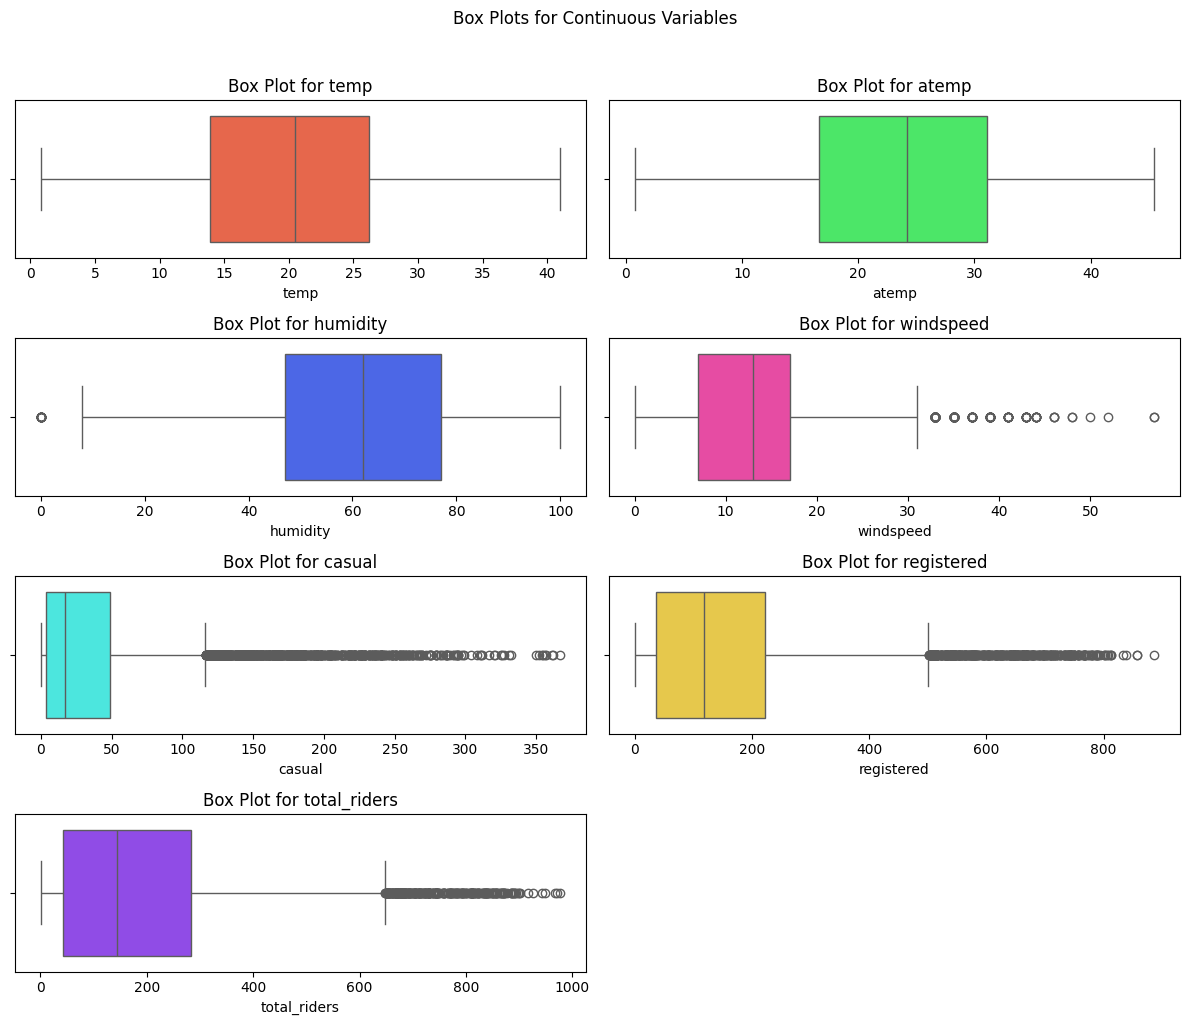

In [17]:
plt.figure(figsize=(12, 10))
fig, axes = plt.subplots(4, 2, figsize=(12, 10))
fig.suptitle("Box Plots for Continuous Variables", y=1.02)
variables = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'total_riders']
colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A6", "#33FFF5", "#FFD733", "#8D33FF"]
axes = axes.flatten()
for i, var in enumerate(variables):
    sns.boxplot(ax=axes[i], x=bike_data[var], color=colors[i])
    axes[i].set_title(f'Box Plot for {var}')

for j in range(len(variables), len(axes)): #To remove Unused plots
   fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **Analyze the distribution**

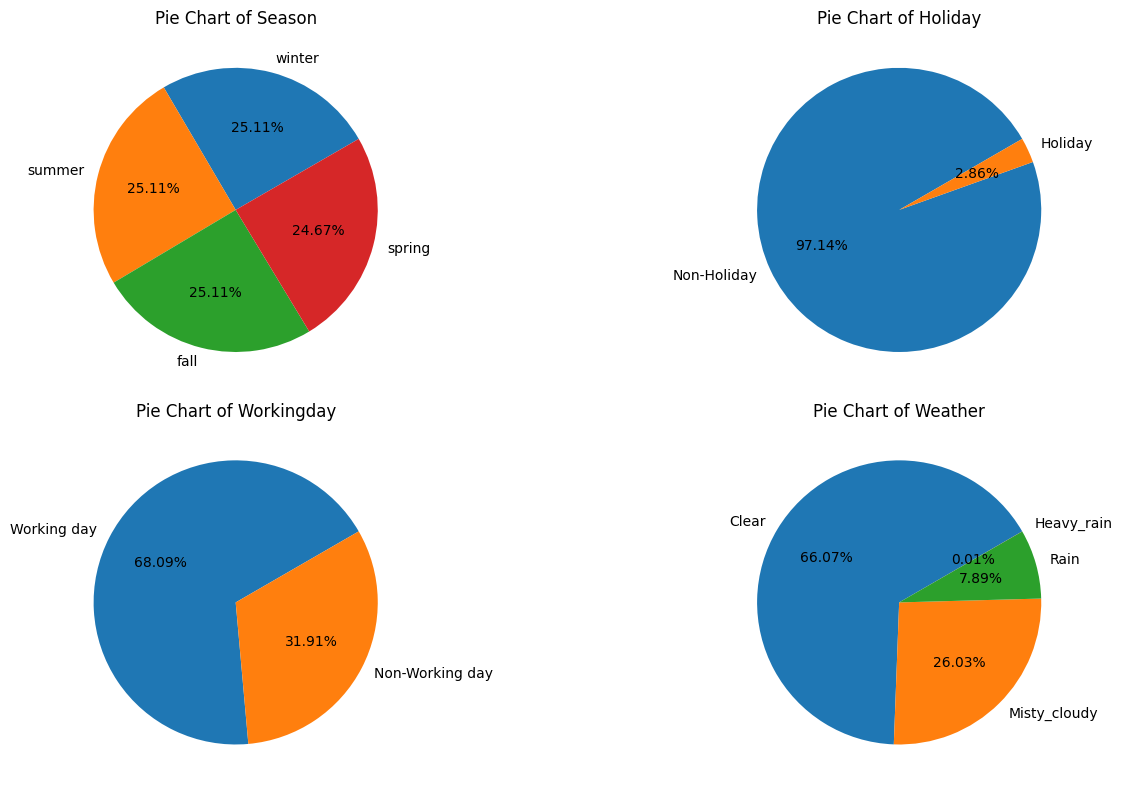

In [18]:
categorical_columns = ['season', 'holiday', 'workingday', 'weather']

fig, axes = plt.subplots(2, 2, figsize=(15, 8))

for i, column in enumerate(categorical_columns):
    row = i // 2
    col = i % 2
    order = bike_data[column].value_counts()
    axes[row, col].pie(order, labels=order.index, autopct='%1.2f%%', startangle=30)
    axes[row, col].set_title(f'Pie Chart of {column.capitalize()}')

plt.tight_layout()
plt.show()

## **Insights and Recommendations**
Seasons:

There's a balanced mix of data for all four seasons (spring, summer, fall, winter) in your dataset. This means you can target promotions throughout the year.

Recommendation:

Design special offers or promotions for each season to keep riders engaged year-round.

Holidays:

We noticed there are fewer rentals on holidays compared to regular days.

Recommendation:  
Run targeted campaigns or promotions specifically during holidays to boost rentals on those days.

Working Days:

The data shows more rentals happening on weekdays compared to weekends.

Recommendation:  
Offer incentives or discounts for riders who use bikes for commuting during work hours. This can encourage weekday rentals.

Weather:

Most rentals occur during clear or slightly cloudy weather. There are fewer rentals on days with mist, rain, thunderstorm, or snow.

Recommendation:

Consider offering rain gear rentals on rainy days to keep riders going even in bad weather.

Promote bike rentals on clear days to capitalize on the favorable weather conditions.

# **Univariate Analysis:**
## **For each Numerical features**

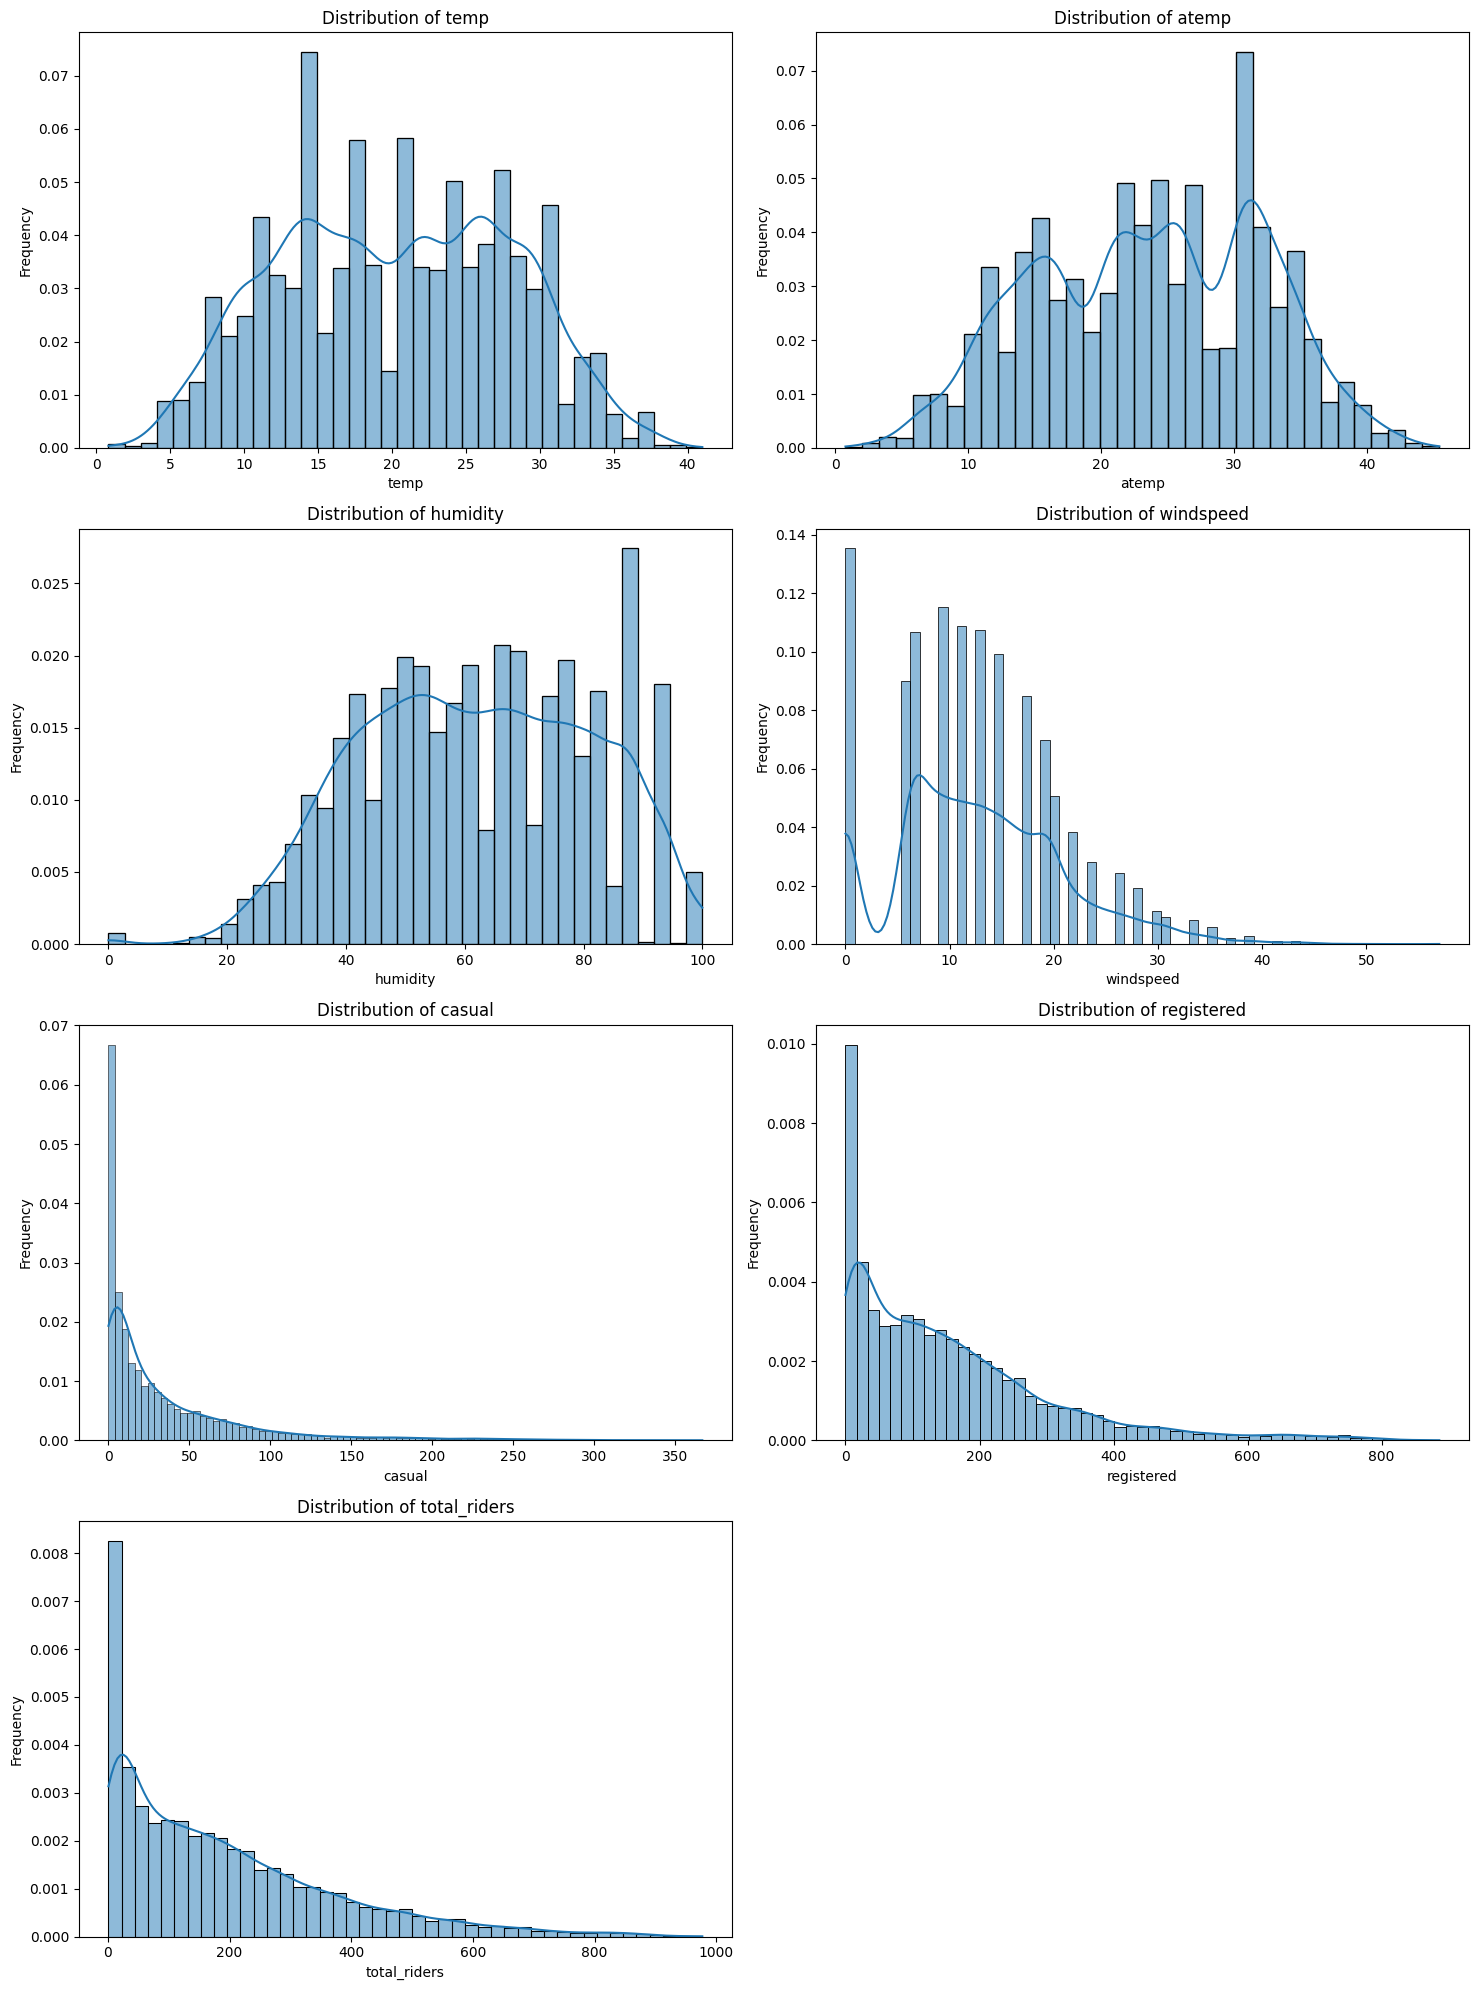

In [19]:
fig, ax = plt.subplots(4, 2, figsize=(15, 20))

# Plot histograms for continuous variables
for i, feature in enumerate(continuous_var):
    row, col = divmod(i, 2)
    sns.histplot(bike_data[feature], kde=True, ax=ax[row, col], line_kws={'color': 'red'}, stat='density',)
    ax[row, col].set_title('Distribution of ' + feature)
    ax[row, col].set_xlabel(feature)
    ax[row, col].set_ylabel('Frequency')

plt.tight_layout()
fig.delaxes(ax[-1, -1])

plt.show()

## **Insights and Recommendations**

Temperature:

The temperature data is nicely balanced, with most rentals happening at a comfortable range.

Recommendation:

Promote bike rentals when the weather is pleasant! This can encourage more people to get outside and enjoy a ride.

Humidity:

We noticed that high humidity is more common than low humidity.

Recommendation:  

Help riders beat the heat! Promote early morning or evening rides when it's cooler.

Wind Speed:

Most days have lower wind speeds, but there can be occasional windy days.

Recommendation:  

Focus on rider safety during windy conditions. Provide information on wind-resistant routes or sheltered areas for riders to enjoy their bike rentals even on windy days.

Number of Riders:

We found that some days have many more rentals than others.

Recommendation:  

Attract more riders on slower days! Develop targeted promotions or discounts to encourage rentals during off-peak times.

Tailor your marketing and services based on the typical weather conditions for each season to get the most riders throughout the year!

# **Relationship between the Dependent and Independent Variables**

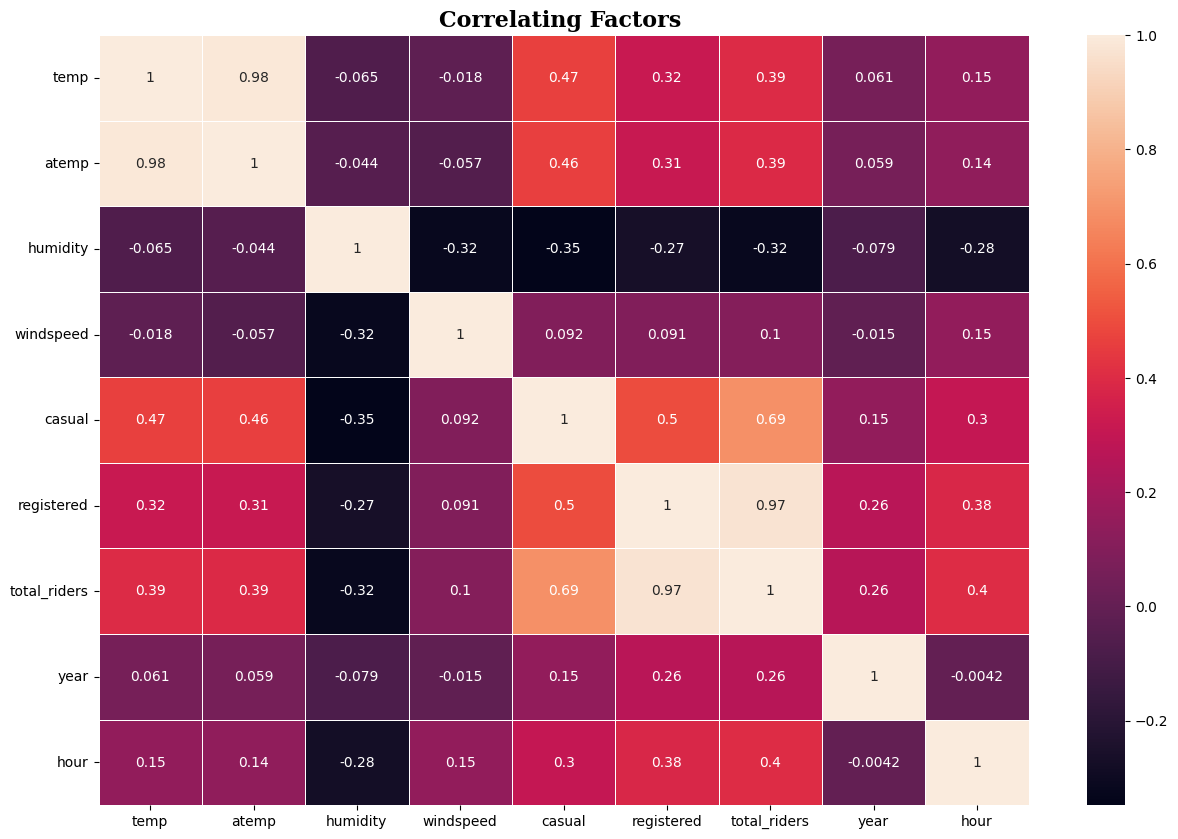

In [20]:
corr_df =  bike_data.corr(numeric_only=True)
plt.figure(figsize=(15,10))
sns.heatmap(bike_data.corr(numeric_only=True), annot=True, linewidth=.5)
plt.yticks(rotation=0)
plt.title('Correlating Factors ',fontfamily='serif',fontweight='bold',fontsize=16)
plt.show()

# **Insights and Recommendations**

Temperature Matters:

Warmer temperatures (including both actual temperature and how it feels) are linked to more bike rentals!

Recommendation:

When the weather forecast predicts comfortable temperatures, promote bike rentals to capitalize on these ideal riding conditions.

Humidity Has an Impact:

We noticed that drier days (lower humidity) tend to have more bike rentals.

Recommendation:  

Consider offering promotions or discounts on days with higher humidity to encourage rentals during these times. This can help offset the potential decrease in ridership due to the weather.

Wind Speed is a Factor:

Strong winds can discourage some riders, with slightly fewer rentals happening on windy days.

Recommendation:  

Provide wind-resistant bikes or promote routes that are sheltered from strong winds. This can help maintain ridership even on windy days.

More Users, More Rentals:

The data shows a clear link - the more users you have (both casual and registered riders), the higher the total number of rentals.

Recommendation:  

Increase your marketing efforts to attract new casual riders and incentivize existing registered users. This can significantly boost your overall rentals.

Consider loyalty programs or special offers for frequent riders. This can encourage repeat business and help grow your registered user base.

# **Bivariate Analysis**

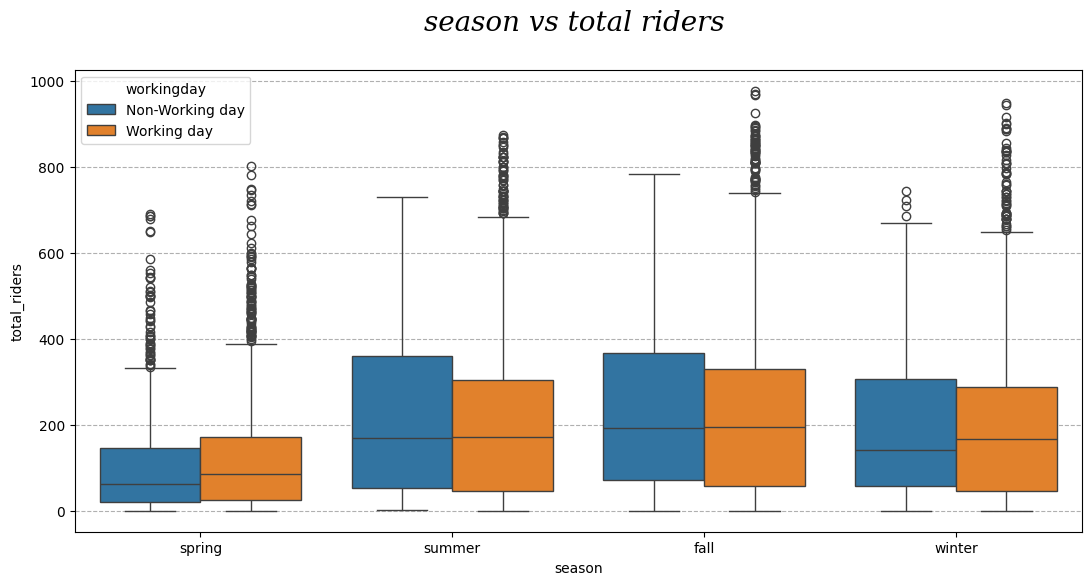

In [21]:
plt.figure(figsize = (13, 6))
plt.title(f'season vs total riders \n',
         fontdict = {'size' : 20,
                    'style' : 'oblique',
                    'family' : 'serif'})
sns.boxplot(data = bike_data, x = 'season', y = 'total_riders', hue = 'workingday')
plt.grid(axis = 'y', linestyle = '--')
plt.show()

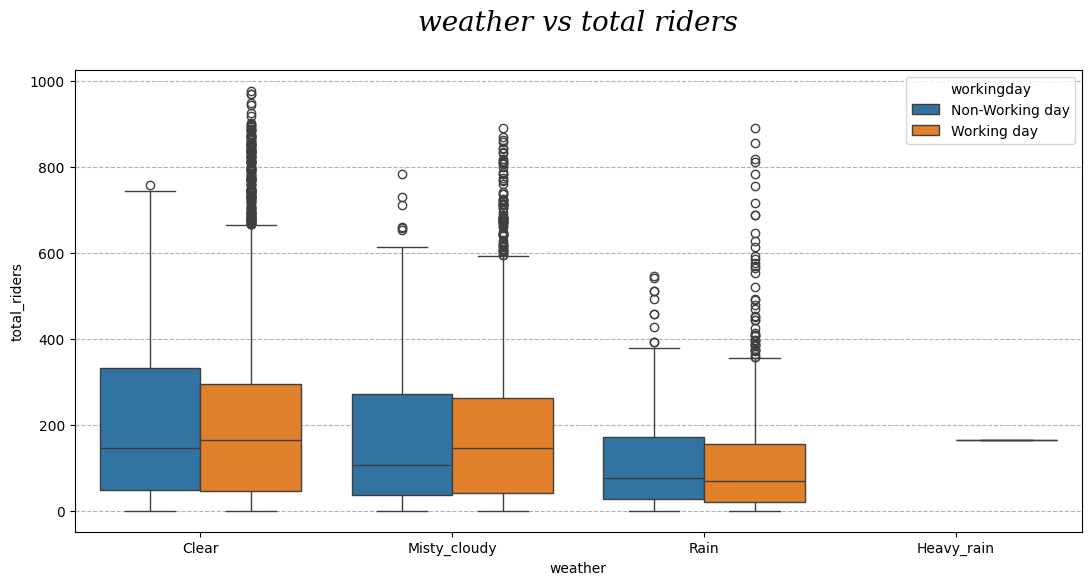

In [22]:
plt.figure(figsize = (13, 6))
plt.title(f'weather vs total riders\n',
         fontdict = {'size' : 20,
                    'style' : 'oblique',
                    'family' : 'serif'})
sns.boxplot(data = bike_data, x = 'weather', y = 'total_riders', hue = 'workingday')
plt.grid(axis = 'y', linestyle = '--')
plt.show()

# **Hypothesis Testing:**

## **Is there any effect of Working Day on the number of electric cycles rented ?**

1. Set up Null and Alternate Hypothesis

* Null Hypothesis ( H0 ) - No.of bikes rented on working days and non working days are same.

* Alternate Hypothesis ( HA ) - No.of bikes rented on working days and non working days are different.

2. Choose the distribution (Gaussian, Binomial, etc), and hence the test statistic.

3. Select the Left vs Right vs Two-Tailed test, as per the hypothesis

4. Compute the P-Value

5. Compare the P-Value to the Significance Level (α) and Fail to reject/reject the Null Hypothesis accordingly.

In [23]:
workingday = bike_data[bike_data['workingday']== 'Working day']['total_riders']
non_workingday = bike_data[bike_data['workingday']== 'Non-Working day']['total_riders']

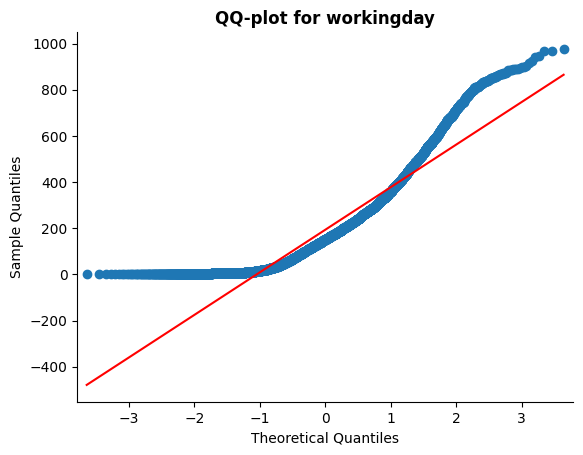

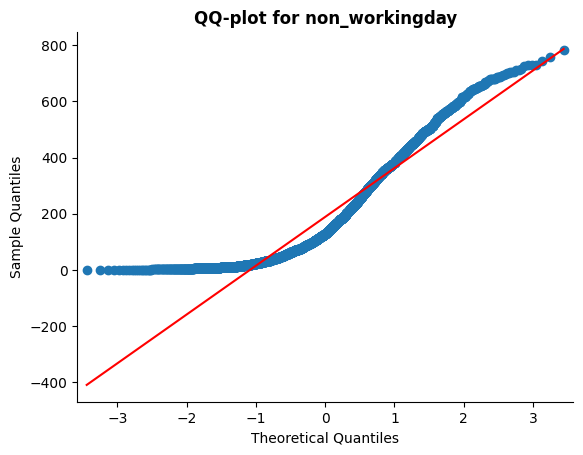

In [24]:
sm.qqplot(workingday,line='s')
plt.title('QQ-plot for workingday',fontsize=12,fontweight="bold")
sns.despine()

sm.qqplot(non_workingday,line='s')
plt.title('QQ-plot for non_workingday',fontsize=12,fontweight="bold")
sns.despine()

plt.show()

## **Shapiro test for workingday**

* Null Hypothesis -- H0 -- Data is Gaussian

* Alternate Hypothesis -- HA -- Data is not Gaussian

In [25]:
shapiro_stat , p_val = shapiro(workingday)
print(f"shapiro_stat : {shapiro_stat} , p_value : {p_val}")

if p_val <= 0.05:
    print('Data does not follow normal distribution \n')
else:
    print('Data follows a normal distribution \n')

shapiro_stat : 0.8702582120895386 , p_value : 0.0
Data does not follow normal distribution 



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [26]:
shapiro_stat , p_val = shapiro(non_workingday)
print(f"shapiro_stat : {shapiro_stat} , p_value : {p_val}")

if p_val <= 0.05:
    print('Data does not follow normal distribution')
else:
    print('Data follows a normal distribution')

shapiro_stat : 0.8852126598358154 , p_value : 4.203895392974451e-45
Data does not follow normal distribution


## **Levene Test**

* Null Hypothesis(Ho) - Data has similar variance

* Alternate Hypothesis(HA) - Data has different variance

In [27]:
levene_stat, p_value = levene(workingday,non_workingday)

print('Levene_stat : ', levene_stat)
print('p-value : ', p_value)

if p_value <= 0.05:
    print('The samples has different variance')
else:
    print('The samples have has similar variance')

Levene_stat :  0.004972848886504472
p-value :  0.9437823280916695
The samples have has similar variance


## **Ttest for Independent Variables**

In [28]:
test_stat, p_value = ttest_ind(workingday,non_workingday)

print(f'ttest_stat : ',test_stat)
print('P-value :',p_value)

if p_value < 0.05:
    print("Reject Null Hypothesis")
    print('No.of bikes rented is not same for working and non-working days')
else:
    print("Failed to Reject Null Hypothesis")
    print('No.of bikes rented is same for working and non-working days')

ttest_stat :  1.2096277376026694
P-value : 0.22644804226361348
Failed to Reject Null Hypothesis
No.of bikes rented is same for working and non-working days


## **Insights and Recommendations**

Our analysis shows that the average number of bikes rented is similar on both working days and non-working days.

Develop targeted marketing campaigns that appeal to a wide range of customers, no matter their work schedule. Consider offering promotions or discounts that cater to different needs and preferences.

Ensure your bike rental process is smooth and efficient on all days of the week. This includes having enough bikes available, regular maintenance, and excellent customer service. A consistent and positive experience keeps customers coming back.

Explore potential collaborations with local businesses, events, or organizations. This can help attract new customers and increase bike rentals on all days of the week. Imagine partnering with a fitness center for weekday morning rides or a festival for weekend rentals.

## **Checking if number of bikes rented is same or different in different weather**

1. Set up Null and Alternate Hypothesis

* Null Hypothesis ( H0 ) -The mean of bikes rented is same for across weather conditions.

* Alternate Hypothesis ( HA ) - The mean number of bikes rented is different across at least two weather conditions.

2. Choose the distribution (Gaussian, Binomial, etc), and hence the test statistic.

3. Select the Left vs Right vs Two-Tailed test, as per the hypothesis

4. Compute the P-Value

5. Compare the P-Value to the Significance Level (α) and Fail to reject/reject the Null Hypothesis accordingly.


In [29]:
Clear = bike_data[bike_data['weather']=='Clear']['total_riders']
misty_cloudy = bike_data[bike_data['weather']=='Misty_cloudy']['total_riders']
Rain = bike_data[bike_data['weather']=='Rain']['total_riders']
Heavy_rain = bike_data[bike_data['weather']=='Heavy rain']['total_riders']

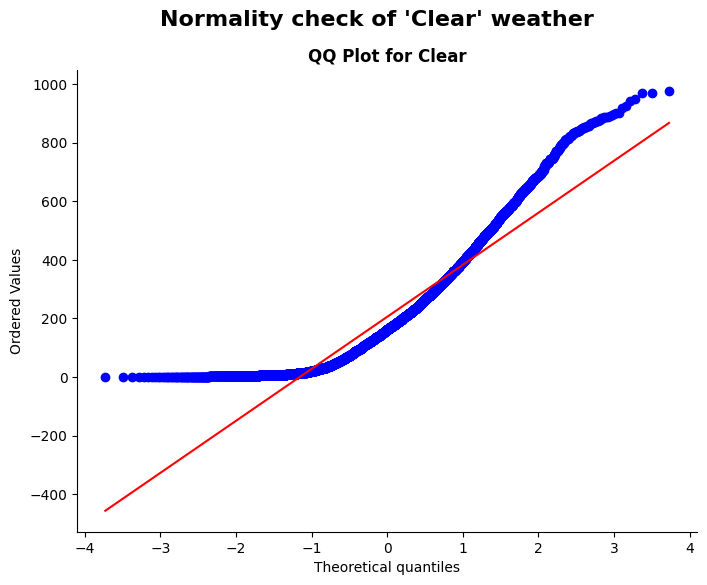

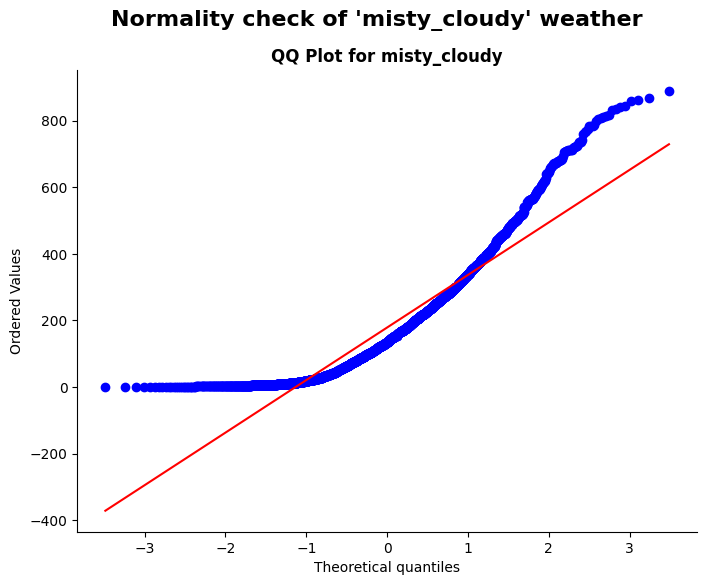

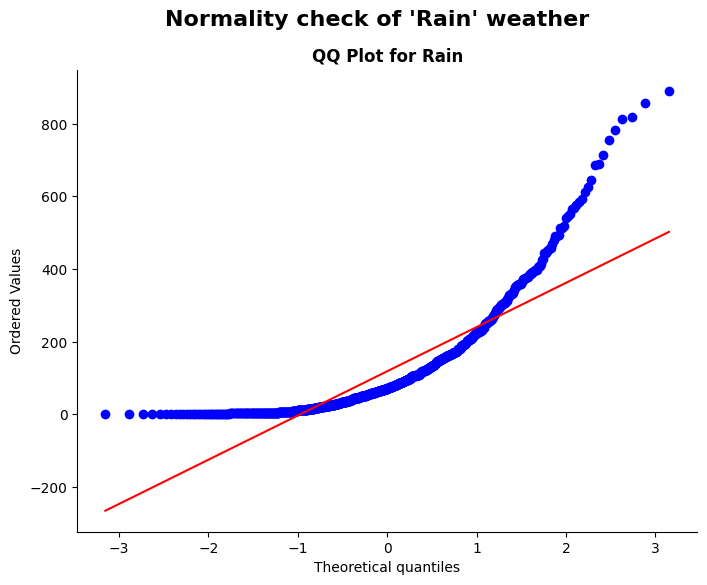

In [30]:
weather_cols = {'Clear': Clear, 'misty_cloudy': misty_cloudy, 'Rain': Rain}

for col_name, data in weather_cols.items():
    plt.figure(figsize=(8, 6))
    plt.suptitle(f'Normality check of \'{col_name}\' weather', fontsize=16, fontweight="bold")

    probplot(data, dist='norm', plot=plt)
    plt.title(f'QQ Plot for {col_name}', fontsize=12, fontweight="bold")

    sns.despine()

    plt.show()


## **Shapiro-Wilk Test:**



In [31]:
weather_cols ={'Clear':Clear, 'misty_cloudy':misty_cloudy, 'Rain': Rain}

for col_name,data in weather_cols.items():
    shapiro_stat , p_val = shapiro(data)
    print(f"shapiro_stat : {shapiro_stat} , p_value : {p_val}")

    if p_val <= 0.05:
        print(f'Data is not Gaussian distribution \n')
    else:
        print(f'Data is Gaussian distribution \n')
    print('-'*125)

shapiro_stat : 0.8909230828285217 , p_value : 0.0
Data is not Gaussian distribution 

-----------------------------------------------------------------------------------------------------------------------------
shapiro_stat : 0.8767687082290649 , p_value : 9.781063280987223e-43
Data is not Gaussian distribution 

-----------------------------------------------------------------------------------------------------------------------------
shapiro_stat : 0.7674332857131958 , p_value : 3.876090133422781e-33
Data is not Gaussian distribution 

-----------------------------------------------------------------------------------------------------------------------------


## **Levene Test**

Null Hypothesis(H0) - Data has similar variance

Alternate Hypothesis(HA) - Data has different variance

In [32]:
levene_stat, p_value = levene(Clear,misty_cloudy,Rain)

print('Levene_stat : ', levene_stat)
print('p-value : ', p_value)

if p_value <= 0.05:
    print('The samples has different variance')
else:
    print('The samples has similar variance')

Levene_stat :  81.67574924435011
p-value :  6.198278710731511e-36
The samples has different variance


The samples are not normally distributed and do not have the same variance, f_oneway test (ANOVA Test) cannot be performed here, we can perform its non parametric equivalent test i.e., Kruskal test for independent samples.

## **Kruskal Test**



In [33]:
alpha = 0.05
test_stat, p_value = kruskal(Clear,misty_cloudy,Rain)
print('Test Statistic =', test_stat)
print('p value =', p_value)

if p_value <= alpha:
    print('Reject Null Hypothesis')
    print("The median of bikes rented is different across at weather conditions")
else:
    print('Failed to reject Null Hypothesis')
    print("The median of bikes rented is same for across weather conditions.")

Test Statistic = 204.95566833068537
p value = 3.122066178659941e-45
Reject Null Hypothesis
The median of bikes rented is different across at weather conditions


The p-value for the kruskal test on weather is extremely low (close to 0), which means that there are statistically significant differences in the number of cycles rented based on different weather conditions.

From both the Krukal-walis test & ANOVA test , we can confirm that The mean number of E-bikes rented differs across various weather conditions.


## **Checking if number of bikes rented is similar or different in different Seasons**

1. Set up Null and Alternate Hypothesis

* Null Hypothesis ( H0 ) - The mean of bikes rented is same for across various Seasons.

* Alternate Hypothesis ( HA ) - The mean number of bikes rented is different for across various seasons.

2. Choose the distribution (Gaussian, Binomial, etc), and hence the test statistic.

3. Select the Left vs Right vs Two-Tailed test, as per the hypothesis

4. Compute the P-Value

5. Compare the P-Value to the Significance Level (α) and Fail to reject/reject the Null Hypothesis accordingly.

In [34]:
summer = bike_data[bike_data['season']=='summer']['total_riders']
winter = bike_data[bike_data['season']=='winter']['total_riders']
fall = bike_data[bike_data['season']=='fall']['total_riders']
spring = bike_data[bike_data['season']=='spring']['total_riders']

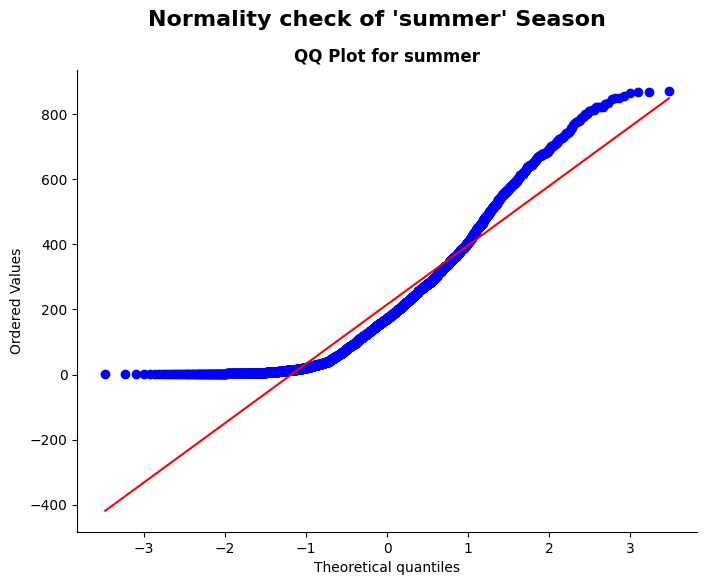

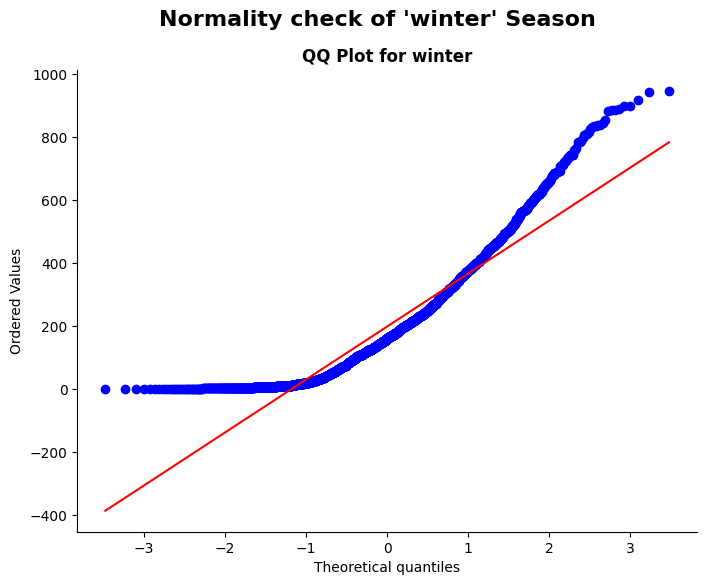

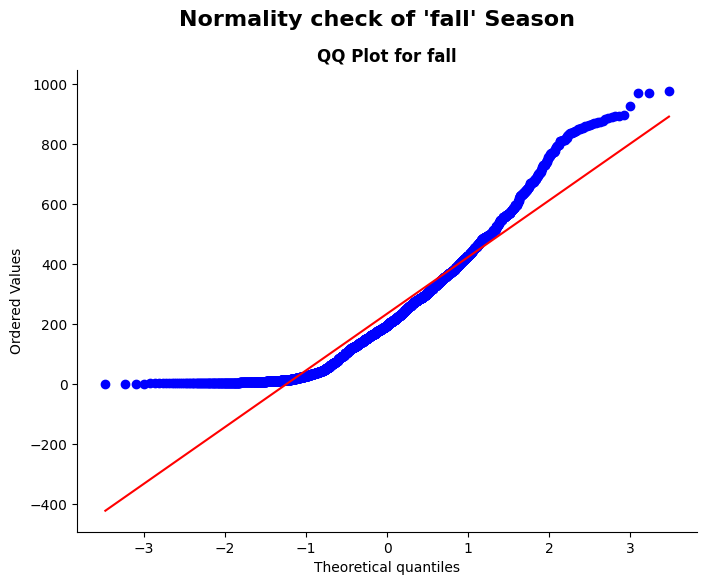

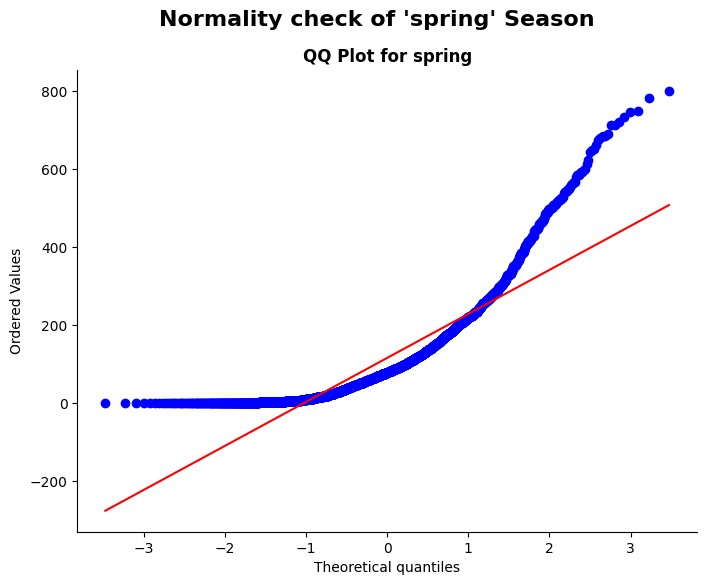

In [35]:
season_cols = {'summer': summer, 'winter': winter, 'fall': fall, 'spring': spring}

for col_name, data in season_cols.items():
    plt.figure(figsize=(8, 6))
    plt.suptitle(f'Normality check of \'{col_name}\' Season', fontsize=16, fontweight="bold")

    probplot(data, dist='norm', plot=plt)
    plt.title(f'QQ Plot for {col_name}', fontsize=12, fontweight="bold")
    sns.despine()

    plt.show()

## **Shapiro-Wilk Test:**


In [36]:
season_cols = {'summer':summer , 'winter':winter , 'fall':fall, 'spring':spring}

for col_name,data in season_cols.items():
    shapiro_stat , p_val = shapiro(data)
    print(f"shapiro_stat : {shapiro_stat} , p_value : {p_val}")

    if p_val < 0.05:
        print(f'Data {col_name} is not Gaussian distribution')
        print()
    else:
        print(f'Data {col_name} is Gaussian distribution')
        print()
    print('-'*125)

shapiro_stat : 0.900481641292572 , p_value : 6.039093315091269e-39
Data summer is not Gaussian distribution

-----------------------------------------------------------------------------------------------------------------------------
shapiro_stat : 0.8954644799232483 , p_value : 1.1301682309549298e-39
Data winter is not Gaussian distribution

-----------------------------------------------------------------------------------------------------------------------------
shapiro_stat : 0.9148160815238953 , p_value : 1.043458045587339e-36
Data fall is not Gaussian distribution

-----------------------------------------------------------------------------------------------------------------------------
shapiro_stat : 0.8087388873100281 , p_value : 0.0
Data spring is not Gaussian distribution

-----------------------------------------------------------------------------------------------------------------------------


## **Levene Test**

In [37]:
levene_stat, p_value = levene(summer,winter,fall,spring)

print('Levene_stat : ', levene_stat)
print('p-value : ', p_value)

if p_value < 0.05:
    print('The samples has different variance')
else:
    print('The samples has similar variance')

Levene_stat :  187.7706624026276
p-value :  1.0147116860043298e-118
The samples has different variance


The samples are not normally distributed and do not have the same variance, f_oneway test (ANOVA Test) cannot be performed here, we can perform its non parametric equivalent test i.e., Kruskal test for independent samples.

## **Kruskal Test**

In [38]:
alpha = 0.05
test_stat, p_value = kruskal(summer,winter,fall,spring)
print('Test Statistic =', test_stat)
print('p value =', p_value)

if p_value < alpha:
    print('Reject Null Hypothesis')
    print("The median of bikes rented is different across seasons")
else:
    print('Failed to reject Null Hypothesis')
    print("The median of bikes rented is same for across seasons.")

Test Statistic = 699.6668548181915
p value = 2.4790083726176776e-151
Reject Null Hypothesis
The median of bikes rented is different across seasons


From above, we can confirm that The mean number of E-bikes rented differs across various Seasons.

## **Are weather comditions significantly same or different for different Seasons?**

1. Set up Null and Alternate Hypothesis

* Null Hypothesis ( H0 ) - weather is independent of season

* Alternate Hypothesis ( HA ) - -weather is dependent of seasons.

2. Choose the distribution (Gaussian, Binomial, etc), and hence the test statistic.

3. Select the Left vs Right vs Two-Tailed test, as per the hypothesis

4. Compute the P-Value

5. Compare the P-Value to the Significance Level (α) and Fail to reject/reject the Null Hypothesis accordingly.



In [39]:
pd.crosstab(bike_data['weather'],bike_data['season'])

season,spring,summer,fall,winter
weather,,,,
Clear,1759,1801,1930,1702
Misty_cloudy,715,708,604,807
Rain,211,224,199,225
Heavy_rain,1,0,0,0


In [42]:
chi_stat , p_value , dof , expected = chi2_contingency(pd.crosstab(bike_data['weather'],bike_data['season']))

print("chi_stat : ",chi_stat)
print("p_value : ",p_value)
print("dof : ",dof)
print("expected : ",expected,'\n')

alpha = 0.05
if p_value< alpha:
    print("Reject Ho")
    print("Weather is dependent on season")
else:
    print("Fail to Reject Ho")
    print("Weather is independent on season")

chi_stat :  49.15865559689363
p_value :  1.5499250736864862e-07
dof :  9
expected :  [[1.77454639e+03 1.80559765e+03 1.80559765e+03 1.80625831e+03]
 [6.99258130e+02 7.11493845e+02 7.11493845e+02 7.11754180e+02]
 [2.11948742e+02 2.15657450e+02 2.15657450e+02 2.15736359e+02]
 [2.46738931e-01 2.51056403e-01 2.51056403e-01 2.51148264e-01]] 

Reject Ho
Weather is dependent on season


## **Insights**

The Chi-square test result (chi2: 49.16) and a very low p-value (almost 0) indicate a statistically significant relationship. This means weather and season are not independent.

Spring and Summer tend to have more favorable weather conditions compared to Fall and Winter.

The weather you experience is strongly linked to the season you're in. Spring and Summer generally bring better weather for riding bikes, while Fall and Winter might have less favorable conditions.

## **Recommendations**

Capitalize on spring and summer's popularity with bike rentals. Offer special discounts or packages during these peak demand months to attract more riders.

Recognize the impact of weather. Create promotions targeting clear and cloudy days with weather-specific discounts to attract more customers during these favorable conditions.

Implement time-based pricing with lower rates during off-peak hours. This encourages rentals when demand is lower, balancing demand and optimizing resources.

Provide amenities like umbrellas, rain jackets, or water bottles to combat high humidity and moderate temperatures. These small touches can significantly improve customer experience and encourage repeat business.

Collaborate with weather services to provide real-time weather updates in your app or marketing campaigns. This allows users to find ideal biking conditions and attracts those with weather preferences.

Allocate resources for seasonal bike maintenance. Conduct thorough checks before peak seasons and maintain bikes regularly year-round to minimize breakdowns and maximize customer satisfaction.

Encourage customer feedback and reviews to identify areas for improvement, understand preferences, and tailor services to better meet expectations.

Offer special discounts on environmental awareness days (Zero Emissions Day, Earth Day, World Environment Day) to attract new users.